In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../zdrojaky/kf')
from kf import KF
from trajectory import trajectory
np.set_printoptions(precision=2)

# 2D object tracking with particle filter

Our task is the filtration of 2D moving object location. We already did this with the Kalman filter, now, we will use the particle filtering methods. 

Recall, that we have a state vector consisting of locations in axes $x_1$ and $x_2$, and velocities in these axes.

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

We know that the $x_1$ location is given by

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

and that the same holds for the second axis. We will assume that the velocity is virtually constant, and its changes are due to the state noise,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogy holds for the other axis. We acquire noisy location measurements, the time step is 0.1s.

The state-space model is

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R),
\end{aligned}
$$

and the covariance matrices are provided below.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
where $dt = 0.1$, $q = 2$, $r=0.5$.

** Task: complete the variables**

In [2]:
q = 2.
dt = .1
r = .2
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                  [0,       dt**3/3, 0,       dt**2/2],
                  [dt**2/2, 0,       dt,      0      ],
                  [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Task: let `code` be the day and month of your birth. In the `traj` object you find the trajectory: 100 rows with locations in both axes. Plot it with crosses.**

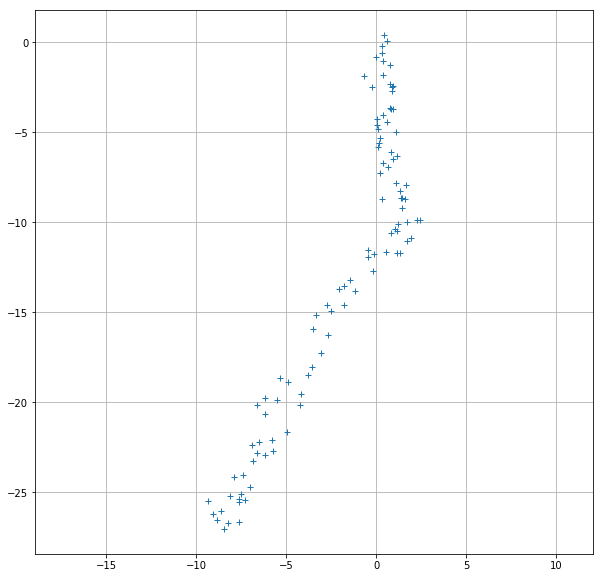

In [3]:
code = 1313
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

**Task: Define the proposal distribution N(0, 10I). Normalize the weights vector.**

In [4]:
ndat = traj.ndat
nsamples = 100
proposal_loc = np.zeros(4)
proposal_cov = 10 * np.eye(4)

samples_x = mvn.rvs(mean=proposal_loc, cov=proposal_cov, size=nsamples)
weights = np.ones(nsamples)
weights /= weights.sum()
print("Weigths check: 1 =", weights.sum())

Weigths check: 1 = 1.0


**Task: complete where you see `###` **

In [5]:
# Logs
log_x = np.zeros((4, ndat))

def prediction(samples_x):
    samples_x_new = np.zeros_like(samples_x)
    for i in range(nsamples):
        mean = A.dot(samples_x[i])
        samples_x_new[i] = mvn.rvs(mean=mean, cov=Q)
    return samples_x_new

def update(yt, samples_x, weights):
    for i in range(nsamples):
        mean = H.dot(samples_x[i])
        likelihood = mvn.pdf(yt, mean=mean, cov=R)
        weights[i] *= likelihood
    weights /= weights.sum()
    return weights

def resample(samples_x, weights):
    indices = np.random.choice(np.arange(weights.size), replace=True, p=weights, size=weights.size)
    samples_x_new = samples_x[indices]
    weights = np.ones_like(weights)/weights.size
    return [samples_x_new, weights]

In [6]:
for t, yt in enumerate(traj.Y.T):
    print('{0} '.format(t), end='')
    
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights[:,np.newaxis], axis=0)
    log_x[:,t] = estimate

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

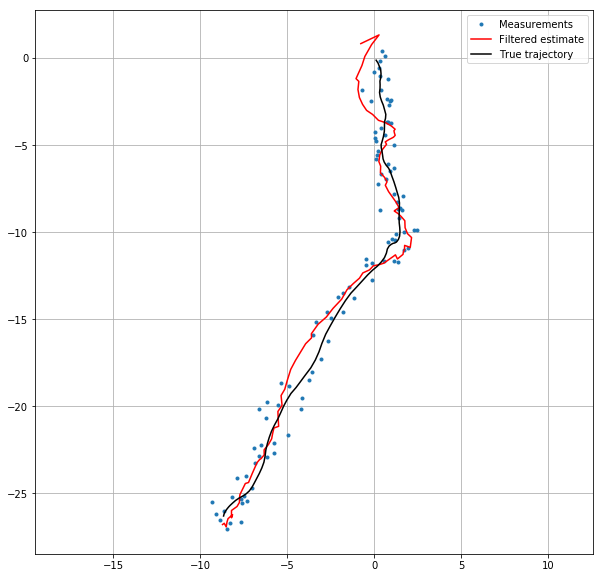

In [7]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Measurements')
plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtered estimate')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='True trajectory')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

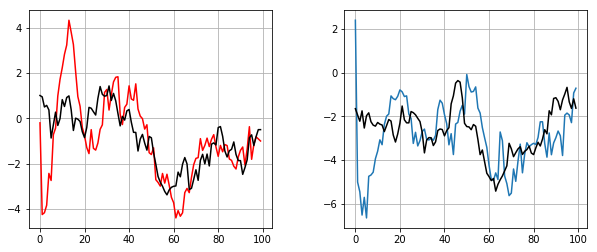

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(log_x[2,:], 'r')
plt.plot(traj.X[2,:], 'k')
plt.subplot(1,2,2)
plt.plot(log_x[3,:])
plt.plot(traj.X[3,:], 'k')
plt.show()